<a href="https://colab.research.google.com/github/florinOK/amr/blob/colab/vae_sentences/vae_matrix_sentences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[Generating Sentences from a Continuous Space](https://arxiv.org/pdf/1511.06349.pdf)  
[Reasoning about Entailment with Neural Attention](https://arxiv.org/pdf/1509.06664.pdf)  
[Deconvolutional Latent-Variable Model for Text Sequence Matching](https://arxiv.org/pdf/1709.07109.pdf)  

---
https://github.com/baaesh/DeConv-VAE-pytorch  
https://github.com/Toni-Antonova/VAE-Text-Generation  
https://github.com/alexeyev/Keras-Generating-Sentences-from-a-Continuous-Space  


In [1]:
! nvidia-smi

Sun Aug 30 12:06:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data

In [3]:
# SNLI
! curl https://nlp.stanford.edu/projects/snli/snli_1.0.zip -o snli_1.0.zip
! unzip snli_1.0.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 90.1M  100 90.1M    0     0  3640k      0  0:00:25  0:00:25 --:--:-- 8636k
Archive:  snli_1.0.zip
replace data/snli_1.0/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
# QQP

In [5]:
# PTB

In [11]:
# Glove
! wget http://nlp.stanford.edu/data/glove.840B.300d.zip
! unzip glove.840B.300d.zip -d data/glove

--2020-08-30 12:12:42--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2020-08-30 12:12:42--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2020-08-30 12:12:43--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

# Code

In [12]:
import re
import json
import time
import logging
import collections

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# import tensorflow_probability as tfp

import matplotlib.pyplot as plt

from IPython import display

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [13]:
p = sns.color_palette()

pd.set_option('display.max_rows', 64)
pd.set_option('display.max_columns', 64)
pd.set_option('display.max_colwidth', 1024)

logging.basicConfig(level='INFO', format="%(asctime)s [%(levelname)-5.5s] [%(funcName)-32s]  %(message)s")

In [14]:
# config

EMBS = 'data/glove/glove.840B.300d.txt'
TEST_DATASET = 'data/snli_1.0/snli_1.0_test.jsonl'
TRAIN_DATASET = 'data/snli_1.0/snli_1.0_train.jsonl'


In [15]:
def load_dataset(path):
    dataset = []
    with open(path) as fp:
        for line in fp.readlines():
            dataset.append(json.loads(line))
    return pd.DataFrame(dataset)


test_dataset = load_dataset(TEST_DATASET)
train_dataset = load_dataset(TRAIN_DATASET)

In [16]:
train_dataset.shape  # (550152, 10)

(550152, 10)

In [17]:
train_dataset.head()

,annotator_labels,captionID,gold_label,pairID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
0,[neutral],3416050480.jpg#4,neutral,3416050480.jpg#4r1n,A person on a horse jumps over a broken down airplane.,( ( ( A person ) ( on ( a horse ) ) ) ( ( jumps ( over ( a ( broken ( down airplane ) ) ) ) ) . ) ),(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN on) (NP (DT a) (NN horse)))) (VP (VBZ jumps) (PP (IN over) (NP (DT a) (JJ broken) (JJ down) (NN airplane)))) (. .))),A person is training his horse for a competition.,( ( A person ) ( ( is ( ( training ( his horse ) ) ( for ( a competition ) ) ) ) . ) ),(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) (VP (VBG training) (NP (PRP$ his) (NN horse)) (PP (IN for) (NP (DT a) (NN competition))))) (. .)))
1,[contradiction],3416050480.jpg#4,contradiction,3416050480.jpg#4r1c,A person on a horse jumps over a broken down airplane.,( ( ( A person ) ( on ( a horse ) ) ) ( ( jumps ( over ( a ( broken ( down airplane ) ) ) ) ) . ) ),(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN on) (NP (DT a) (NN horse)))) (VP (VBZ jumps) (PP (IN over) (NP (DT a) (JJ broken) (JJ down) (NN airplane)))) (. .))),"A person is at a diner, ordering an omelette.","( ( A person ) ( ( ( ( is ( at ( a diner ) ) ) , ) ( ordering ( an omelette ) ) ) . ) )","(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) (PP (IN at) (NP (DT a) (NN diner))) (, ,) (S (VP (VBG ordering) (NP (DT an) (NN omelette))))) (. .)))"
2,[entailment],3416050480.jpg#4,entailment,3416050480.jpg#4r1e,A person on a horse jumps over a broken down airplane.,( ( ( A person ) ( on ( a horse ) ) ) ( ( jumps ( over ( a ( broken ( down airplane ) ) ) ) ) . ) ),(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN on) (NP (DT a) (NN horse)))) (VP (VBZ jumps) (PP (IN over) (NP (DT a) (JJ broken) (JJ down) (NN airplane)))) (. .))),"A person is outdoors, on a horse.","( ( A person ) ( ( ( ( is outdoors ) , ) ( on ( a horse ) ) ) . ) )","(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) (ADVP (RB outdoors)) (, ,) (PP (IN on) (NP (DT a) (NN horse)))) (. .)))"
3,[neutral],2267923837.jpg#2,neutral,2267923837.jpg#2r1n,Children smiling and waving at camera,( Children ( ( ( smiling and ) waving ) ( at camera ) ) ),(ROOT (NP (S (NP (NNP Children)) (VP (VBG smiling) (CC and) (VBG waving) (PP (IN at) (NP (NN camera))))))),They are smiling at their parents,( They ( are ( smiling ( at ( their parents ) ) ) ) ),(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VBG smiling) (PP (IN at) (NP (PRP$ their) (NNS parents)))))))
4,[entailment],2267923837.jpg#2,entailment,2267923837.jpg#2r1e,Children smiling and waving at camera,( Children ( ( ( smiling and ) waving ) ( at camera ) ) ),(ROOT (NP (S (NP (NNP Children)) (VP (VBG smiling) (CC and) (VBG waving) (PP (IN at) (NP (NN camera))))))),There are children present,( There ( ( are children ) present ) ),(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NNS children)) (ADVP (RB present)))))


# Vocab

In [18]:
class WordModel:
    
    def __init__(self, word_regex=r'([A-Za-z]+|[\s]|[^A-Za-z\s])'):
        self.word_regex = re.compile(word_regex)

    def preprocess_sentence(self, sentence):
        sentence = sentence.lower()
        return sentence

    def parse_sentence(self, sentence):
        sentence = self.preprocess_sentence(sentence)
        words = self.word_regex.findall(sentence)
        words = [word for word in words if word != ' ']  # hack short length: words = [word for word in words[:8] if word != ' ']
        return words
    
    def parse_corpus(self, sentences):
        words = []
        for sentence in sentences:
            words += self.parse_sentence(sentence)
        return words


In [19]:
word_model = WordModel()

train_words = word_model.parse_corpus(train_dataset['sentence1'])
train_words += word_model.parse_corpus(train_dataset['sentence2'])

In [20]:
class WordVocab:

    def __init__(self, max_size_vocab=100000):
        self.max_size_vocab = max_size_vocab
        self.vocab = None
        self.vocab_reversed = None
        self.util_vocab = {'[PAD]': 0, '[UNK]': 1}
        self.util_vocab_reversed = {v: k for k, v in self.util_vocab.items()}
    
    @property
    def vocab_size(self):
        return len(self.vocab)
    
    def create_vocab(self, words):
        word_counts = collections.Counter(words)
        word_counts = word_counts.most_common(self.max_size_vocab)

        initial_index = len(self.util_vocab)
        self.vocab = {
            **self.util_vocab,
            **{word: i for i, (word, _) in enumerate(word_counts, initial_index)}
        }
        self.vocab_reversed = {v: k for k, v in self.vocab.items()}
    
    def pad_words(self, words, max_length):
        words = words + ['[PAD]'] * (max_length - len(words))
        return words[:max_length]

    def encode_words(self, words):
        unk_code = self.vocab['[UNK]']
        return [self.vocab.get(word, unk_code) for word in words]
    
    def decode_words(self, words):
        unk_word = '[UNK]'
        return [self.vocab_reversed.get(word, unk_word) for word in words]


In [21]:
max_size_vocab = 8000


word_vocab = WordVocab(max_size_vocab)
word_vocab.create_vocab(train_words)

In [22]:
word_vocab.vocab_size

8002

In [23]:
len([word for word in train_words if word in word_vocab.vocab]) / len(train_words)

0.9900431405924083

# embs

In [24]:
emb_size = 300

In [ ]:
word_embeddings = {}

with open(EMBS, 'r', encoding='utf-8') as fp:
    for line in fp:
        values = line.strip().split()
        word = ' '.join(values[:-300])
        word_embeddings[word] = np.asarray(values[-300:], 'float32')


In [ ]:
len(word_embeddings)

2195895

In [ ]:
# space is part of word
# [word for word in word_embeddings if ' ' in word]

##### check words without embeddings

In [ ]:
# check word embeddings
len([word for word in word_vocab.vocab if word in word_embeddings]) / word_vocab.vocab_size

0.9991252186953262

In [ ]:
[word for word in word_vocab.vocab if word not in word_embeddings]

['[PAD]',
 '[UNK]',
 'rollerskaters',
 'surfboarder',
 'graffited',
 'parasailer',
 'boogieboard']

##### init emb matrix

In [ ]:
embeddings = [
    word_embeddings[word] if word in word_embeddings else np.random.uniform(-0.05, 0.05, 300)
    for word, _ in sorted(word_vocab.vocab.items(), key=lambda x: x[1])
]
embeddings = np.array(embeddings)

In [ ]:
embeddings.shape

(8002, 300)

# phrase structure

In [38]:
def parse_phrase_structure(string):
    items = string.split()
    
    nodes = [{'index': 0, 'childs': [], 'words': []}]
    words = []
    parents = [0]
    for item in items:
        if item == '(':
            # link child to parent
            nodes[parents[-1]]['childs'].append(len(nodes))
            # add node
            node = {
                'index': len(nodes),
                'childs': [],
                'words': []
            }
            nodes.append(node)
            # add new parent
            parents.append(len(nodes) - 1)
        
        elif item == ')':
            # update last parent
            parents = parents[:-1]
        
        else:
            # add word to last node
            words.append(item)
            nodes[parents[-1]]['words'].append({'word': item, 'index': len(words) - 1})

    return nodes


In [39]:
def get_words(nodes):
    words = [word for node in nodes for word in node['words']]
    words = [word['word'] for word in sorted(words, key=lambda x: x['index'])]
    return words


def get_matrix_words_nodes(nodes):
    words = get_words(nodes)
    
    matrix = np.zeros((len(nodes), len(words)))
    for node in nodes:
        word_indexes = [word['index'] for word in node['words']]
        matrix[node['index'], word_indexes] = 1
    return matrix


def get_matrix_words_childs(nodes):
    words = get_words(nodes)
    
    matrix = np.zeros((len(nodes), len(words)))
    for node in nodes:
        childs = [node['index']]
        while childs:
            child_node_index, *childs = childs
            word_indexes = [word['index'] for word in node['words']]
            matrix[child_node_index, word_indexes] = 1
            childs += nodes[child_node_index]['childs']
    
    matrix = matrix[1:, :]  # rm root
    return matrix


def get_matrix_words_parents(nodes):
    words = get_words(nodes)
    
    matrix = np.zeros((len(nodes), len(words)))
    for node in nodes:
        childs = [node['index']]
        while childs:
            child_node_index, *childs = childs
            word_indexes = [word['index'] for word in nodes[child_node_index]['words']]
            matrix[node['index'], word_indexes] = 1
            childs += nodes[child_node_index]['childs']
    
    matrix = matrix[1:, :]  # rm root
    return matrix


##### *how it works*

In [47]:
string = train_dataset['sentence1_binary_parse'][0]
string

'( ( ( A person ) ( on ( a horse ) ) ) ( ( jumps ( over ( a ( broken ( down airplane ) ) ) ) ) . ) )'

In [ ]:
nodes = parse_phrase_structure(string)
nodes

In [ ]:
words = get_words(nodes)
words

In [ ]:
matrix_words_childs = get_matrix_words_childs(nodes)
matrix_words_childs

In [ ]:
matrix_words_childs = get_matrix_words_childs(nodes)
matrix_words_childs /= matrix_words_childs.sum(axis=0)
matrix_words_childs = np.dot(matrix_words_childs.transpose(), matrix_words_childs)
matrix_words_childs

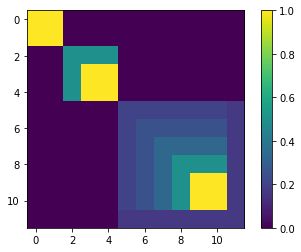

In [55]:
plt.imshow(matrix_words_childs)
plt.colorbar()
plt.show()

In [ ]:
matrix_words_parents = get_matrix_words_parents(nodes)
matrix_words_parents

In [ ]:
matrix_words_parents = get_matrix_words_parents(nodes)
matrix_words_parents /= matrix_words_parents.sum(axis=0)
matrix_words_parents = np.dot(matrix_words_parents.transpose(), matrix_words_parents)
matrix_words_parents

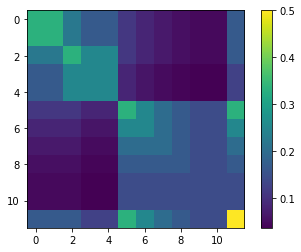

In [52]:
plt.imshow(matrix_words_parents)
plt.colorbar()
plt.show()

# Dataset

In [ ]:
# check max_length
# lengths = [len(word_model.parse_sentence(sentence)) for sentence in train_dataset['sentence1']]
# np.min(lengths), np.max(lengths), np.mean(lengths), len([length for length in lengths if length < 32]) / len(lengths)

In [77]:
max_length = 32
batch_size = 32

test_size = 10000
train_size = 100000


def process_sentence(sentence):
    words = word_model.parse_sentence(sentence)
    words = word_vocab.pad_words(words, max_length)
    words = word_vocab.encode_words(words)
    return words


def process_sentence_structure(string):
    nodes = parse_phrase_structure(string)

    matrix_words_parents = get_matrix_words_parents(nodes)
    matrix_words_parents /= matrix_words_parents.sum(axis=0)
    matrix_words_parents = np.dot(matrix_words_parents.transpose(), matrix_words_parents)

    matrix = np.zeros((max_length, max_length))
    shape_0 = min(max_length, matrix_words_parents.shape[0])
    shape_1 = min(max_length, matrix_words_parents.shape[1])
    matrix[:shape_0, :shape_1] += matrix_words_parents[:shape_0, :shape_1]
    return matrix


test_sentences = [process_sentence(s) for s in test_dataset['sentence1']]
test_sentences += [process_sentence(s) for s in test_dataset['sentence2']]
test_sentences = np.array(test_sentences)

test_sentence_structures = [process_sentence_structure(s) for s in test_dataset['sentence1_binary_parse']]
test_sentence_structures += [process_sentence_structure(s) for s in test_dataset['sentence2_binary_parse']]
test_sentence_structures = np.array(test_sentence_structures)


# train_sentences = [process_sentence(s) for s in train_dataset['sentence1']]
# train_sentences += [process_sentence(s) for s in train_dataset['sentence2']]
# train_sentences = np.array(train_sentences)
train_sentences = [process_sentence(s) for s in test_dataset['sentence1']]
train_sentences += [process_sentence(s) for s in test_dataset['sentence2']]
train_sentences = np.array(train_sentences)

# train_sentence_structures = [process_sentence_structure(s) for s in train_dataset['sentence1_binary_parse']]
# train_sentence_structures += [process_sentence_structure(s) for s in train_dataset['sentence2_binary_parse']]
# train_sentence_structures = np.array(train_sentence_structures)
train_sentence_structures = [process_sentence_structure(s) for s in test_dataset['sentence1_binary_parse']]
train_sentence_structures += [process_sentence_structure(s) for s in test_dataset['sentence2_binary_parse']]
train_sentence_structures = np.array(train_sentence_structures)


test_sentences = {
    'sentence': test_sentences,
    'sentence_structure': test_sentence_structures
}

test_sentences = (
    tf.data.Dataset.from_tensor_slices(test_sentences)
    .shuffle(test_size)
    .batch(batch_size)
)

train_sentences = {
    'sentence': train_sentences,
    'sentence_structure': train_sentence_structures
}
train_sentences = (
    tf.data.Dataset.from_tensor_slices(train_sentences)
    .shuffle(train_size)
    .batch(batch_size)
)
# list(test_sentences.as_numpy_iterator())[0]

# Model

### positional encoding

In [ ]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates


In [ ]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


##### *how it works*

(1, 50, 512)


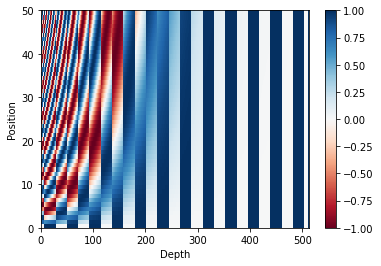

In [ ]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.xlim((0, 512))
plt.xlabel('Depth')
plt.ylabel('Position')
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.colorbar()
plt.show()

### attention function

In [189]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)


In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
                to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    return output, attention_weights


##### *how it works*

In [ ]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)


In [ ]:
# np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[8.433274e-26 1.000000e+00 8.433274e-26 8.433274e-26]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[1.000000e+01 9.276601e-25]], shape=(1, 2), dtype=float32)


### Attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights


### VAE

In [247]:
latent_dim = 512

In [248]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()

        self.seq = tf.keras.layers.InputLayer(input_shape=(max_length))
        self.emb = tf.keras.layers.Embedding(
            word_vocab.vocab_size, emb_size,
            # embeddings_initializer=tf.keras.initializers.Constant(embeddings),
            # trainable=False
        )

        self.conv_1 = tf.keras.layers.Conv1D(
            filters=300, kernel_size=3, strides=2, activation='relu'
        )
        self.conv_2 = tf.keras.layers.Conv1D(
            filters=512, kernel_size=3, strides=2, activation='relu'
        )
        self.conv_3 = tf.keras.layers.Conv1D(
            filters=512, kernel_size=3, strides=2, activation='relu'
        )

        self.flatten = tf.keras.layers.Flatten()
        self.latent = tf.keras.layers.Dense(latent_dim + latent_dim)

    def call(self, x, training=None):
        seq = self.seq(x)  # (32, 32)
        emb = self.emb(seq)  # (32, 32, 300)

        conv_1 = self.conv_1(emb)  # (32, 15, 300)
        conv_2 = self.conv_2(conv_1)  # (32, 7, 512)
        conv_3 = self.conv_3(conv_2)  # (32, 3, 512)

        flatten = self.flatten(conv_3)  # (32, 1536)
        latent = self.latent(flatten)  # (32, 1024)
        return latent


In [270]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()

        self.seq = tf.keras.layers.InputLayer(input_shape=(latent_dim,))
        self.dense = tf.keras.layers.Dense(units=4 * 512, activation=tf.nn.relu)
        self.reshape = tf.keras.layers.Reshape(target_shape=(4, 512))

        self.conv_1 = tf.keras.layers.Conv1DTranspose(
            filters=512, kernel_size=3, strides=2, padding='same', activation='relu'
        )
        self.conv_2 = tf.keras.layers.Conv1DTranspose(
            filters=512, kernel_size=3, strides=2, padding='same', activation='relu'
        )
        self.conv_3 = tf.keras.layers.Conv1DTranspose(
            filters=300, kernel_size=3, strides=2, padding='same', activation='relu'
        )
        # No activation
        self.embeddings = tf.keras.layers.Conv1D(
            filters=300, kernel_size=1, strides=1, activation='relu'
        )
        self.logits = tf.keras.layers.Conv1DTranspose(
            filters=word_vocab.vocab_size, kernel_size=3, strides=1, padding='same'
        )

    def call(self, x, training=None):
        seq = self.seq(x)  # (32, 512)
        seq = self.dense(seq)  # (32, 2048)
        seq = self.reshape(seq)  # (32, 4, 512)

        conv_1 = self.conv_1(seq)  # (32, 8, 512)
        conv_2 = self.conv_2(conv_1)  # (32, 16, 512)
        conv_3 = self.conv_3(conv_2)  # (32, 32, 300)

        embeddings = self.embeddings(conv_3)  # (32, 32, 300)
        logits = self.logits(conv_3)  # (32, 32, 6002)
        return embeddings, logits


In [271]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = Encoder()
        self.decoder = Decoder()

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, log_variance = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, log_variance

    def reparameterize(self, mean, log_variance):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(log_variance * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        embeddings, logits = self.decoder(z)
        if apply_sigmoid:
            logits = tf.sigmoid(logits)
        return embeddings, logits


In [272]:
def create_padding_matrix_mask(sequence):
    sequence_mask = tf.cast(tf.math.not_equal(sequence, 0), tf.float32)
    sequence_mask = sequence_mask[:, :, tf.newaxis]
    matrix_mask = tf.matmul(sequence_mask, sequence_mask, transpose_b=True)
    return matrix_mask


In [273]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, log_variance, raxis=1):
    log_2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-0.5 * ((sample - mean) ** 2. * tf.exp(-log_variance) + log_variance + log_2pi), axis=raxis)


def compute_loss(model, x):
    mean, log_variance = model.encode(x['sentence'])
    z = model.reparameterize(mean, log_variance)

    x_embeddings, x_logits = model.decode(z)

    x_labels = tf.one_hot(x['sentence'], depth=word_vocab.vocab_size, dtype='float32')
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logits, labels=x_labels)
    loss_0 = -tf.reduce_sum(cross_entropy, axis=[1, 2])

    x_structure = tf.cast(x['sentence_structure'], dtype='float32')
    x_adj_matrix = tf.matmul(x_embeddings, x_embeddings, transpose_b=True)
    mse_structure = tf.square(x_structure - x_adj_matrix)
    mse_structure *= create_padding_matrix_mask(x['sentence'])
    loss_1 = -tf.reduce_sum(mse_structure, axis=[1, 2])

    log_px_z = loss_0 + 0.0001 * loss_1
    log_pz = log_normal_pdf(z, 0., 0.)
    log_qz_x = log_normal_pdf(z, mean, log_variance)
    return -tf.reduce_mean(log_px_z + log_pz - log_qz_x)


@tf.function
def train_step(model, sample, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, sample)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [274]:
def decode_sentences(sentences):
    sentences = [word_vocab.decode_words(sentence) for sentence in sentences]
    sentences = [' '.join(sentence) for sentence in sentences]
    return sentences


def generate_sentences(model, sample):
    mean, log_variance = model.encode(sample['sentence'])
    z = model.reparameterize(mean, log_variance)

    embeddings, predictions = model.sample(z)
    predictions = np.argmax(predictions, axis=-1)
    return decode_sentences(predictions)


# Training

In [275]:
tf.keras.backend.clear_session()

In [276]:
epochs = 200
num_examples_to_generate = 8

model = CVAE(latent_dim)

In [277]:
for sample in test_sentences.take(1):
    test_sample = sample


In [278]:
for sentence in decode_sentences(test_sample['sentence'].numpy()[:num_examples_to_generate]):
    print(sentence)


a little girl on a piece of playground equipment [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
an elderly women is sitting in a chair on one side of a room with a group of musicians , including a cellist and guitar player , and on the other side
a man in a green shirt and a red kilt is juggling three clubs . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
a man holding girl at top of a slide [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
an asian woman is standing on a path with a basket on her head looking into a mirror she is holding in her hand . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
a man painting a sign onto his food cart . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [ ]:
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for sample in train_sentences:
        train_step(model, sample, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for sample in test_sentences:
        loss(compute_loss(model, sample))
    
    elbo = -loss.result()
    display.clear_output(wait=False)

    print(f'Epoch: {epoch}, Test set ELBO: {elbo}, time elapse for current epoch: {end_time - start_time}')
    for sentence in generate_sentences(model, test_sample)[:num_examples_to_generate]:
        print(sentence)
    print()


# Epoch: 1, Test set ELBO: -115.2772, time elapse for current epoch: 57.4233  # loss_0
# Epoch: 1, Test set ELBO: -575.9433, time elapse for current epoch: 59.3671  # loss_0 + 0.0001 * loss_1

Epoch: 54, Test set ELBO: -63.927154541015625, time elapse for current epoch: 57.03461575508118
a man is is a a a a [UNK] . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
a man in in a a a , , a , a a and a a a a a a , the , a a a a in the in . [PAD]
a man in a red shirt is a a a a a a the . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
a people are is a a a the [UNK] . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
a men are in a a a , , a a a a a a a a in a in a in the . . . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
a man is a a a a a . . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
a man is in a a a a a a a a a the the . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

# Test

In [ ]:
# 200 epochs - train = valid 10000 samples - 200 epochs - no embs pretrained
# five young indian girls dress in colorful dresses are holding hands and smiling forming a circle [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man in a black suit with a cat on a leash is looking in a shop while the cat stands beside him staring the opposite direction of the man , as
# these are young adults who seem to be working together to protect the plants surrounding the white pole . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# an older man wearing a suit has his arms folded behind his back and looking in a store window . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man in a suit with gold buttons and a name tag gestures with his hands as he speaks to another man in a dress shirt who is holding a beverage in
# a teen is standing in a field and is in the upswing position after hitting a golf ball . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a skateboarder getting ready to perform on a half - tube rink where there are trees in the background . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man is smiling at a woman in a white dress . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

# Epoch: 200, Test set ELBO: -31.7231, time elapse for current epoch: 20.1175
# five young indian girls dress a colorful dresses are holding hands and smiling forming in circle [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a woman in a black suit with a cat on a leash is looking in a shop while the cat stands beside him staring while a direction of the background , as
# these are young adults who seem to be working together to protect the plants surrounding the white pole . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# an older man wearing a suit has makes arms folded behind his back and looking in a store window . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a woman in a suit with gold buttons and a name tag gestures with his hands as he speaks to another man in a dress shirt who is holding a beverage khaki
# a teen boy standing in black field and is in the upswing position after hitting in golf ball . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a skateboarder getting ready to perform on a half - tube rink where there are trees in the background . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
# a man is smiling in a escalator in a white dress . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [ ]:
def get_exact_match_score(sample, prediction):
    sample = [word for word in sample if word != '[PAD]']

    head = [1 for s_word, p_word in zip(sample, prediction) if s_word == p_word]
    tail = [1 for word in prediction[len(sample):] if word != '[PAD]']

    score = (sum(head) - sum(tail)) / len(sample)
    return score


In [ ]:
scores = []

for sample in test_sentences:
    sentences = decode_sentences(sample.numpy())
    predictions = generate_sentences(model, sample)

    scores += [
        get_exact_match_score(sentence, prediction)
        for sentence, prediction in zip(sentences, predictions)
    ]
      

np.min(scores), np.max(scores), np.mean(scores)

(-0.1286549707602339, 1.0, 0.28382985152632745)

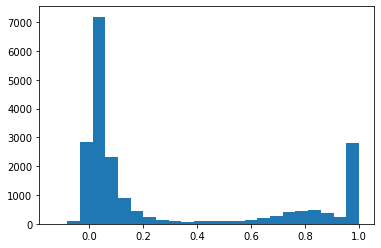

In [ ]:
plt.hist(scores, bins='auto')
plt.show()